# ASL Alphabet — Pre‑Training EDA (Grayscale, Full Scan)

**Goal:** Scan every training image and collect training‑relevant metadata with minimal compute. Output a CSV and save PNG plots you can include in your report.

**Outputs:**
- `asl_alphabet_eda_summary.csv` — one row per image (path, label, width, height, mean/std intensity, blur score, file size)
- `eda_outputs/` — PNGs: class distribution, intensity distribution, blur distribution, dimension distribution, feature correlation

**Notes:**
- Dataset root is assumed to be `ASL_Alphabet/asl_alphabet_train`. Override via env var `ASL_DATA_DIR` if needed.
- Images are loaded as **grayscale** only; skip any color analysis.


In [1]:
# Cell 1 — Environment & Dependencies (safe to re-run)
import sys, subprocess, pkgutil
def _pip_install(pkg):
    if pkg not in {m.name for m in pkgutil.iter_modules()}:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for pkg in ["opencv-python", "matplotlib", "pandas", "numpy", "tqdm", "seaborn"]:
    try:
        _pip_install(pkg)
    except Exception as e:
        print(f"Warning: couldn't verify/install {pkg}: {e}")
print("Dependencies ready.")

Installing opencv-python...
  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4
Dependencies ready.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Cell 2 — Imports & Paths
import os
from pathlib import Path
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# === Base directory ===
# points to the project root (the parent of 'notebooks')
BASE_DIR = Path(__file__).resolve().parents[1] if "__file__" in locals() else Path.cwd().parent

# Dataset directories (relative to project root)
DATA_DIR = Path(os.environ.get("ASL_DATA_DIR", BASE_DIR / "data/labeled/train"))
VAL_DIR = Path(os.environ.get("ASL_VAL_DIR", BASE_DIR / "data/labeled/val"))
TEST_DIR = Path(os.environ.get("ASL_TEST_DIR", BASE_DIR / "data/unlabeled"))

# Output locations
OUT_CSV = BASE_DIR / "notebooks" / "asl_alphabet_eda_summary.csv"
OUT_PLOTS_DIR = BASE_DIR / "notebooks" / "eda_outputs"
OUT_PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Debug info
print(f"BASE_DIR:  {BASE_DIR.resolve()}")
print(f"TRAIN_DIR: {DATA_DIR.resolve()}")
print(f"VAL_DIR:   {VAL_DIR.resolve()}")
print(f"TEST_DIR:  {TEST_DIR.resolve()}")
print(f"Outputs →  {OUT_CSV.name}, {OUT_PLOTS_DIR.resolve()}")

# Seaborn theme
sns.set_context("notebook")


BASE_DIR:  /home/genesis/sem1_project/sign-to-speech-with-temporal-correction
TRAIN_DIR: /home/genesis/sem1_project/sign-to-speech-with-temporal-correction/data/labeled/train
VAL_DIR:   /home/genesis/sem1_project/sign-to-speech-with-temporal-correction/data/labeled/val
TEST_DIR:  /home/genesis/sem1_project/sign-to-speech-with-temporal-correction/data/unlabeled
Outputs →  asl_alphabet_eda_summary.csv, /home/genesis/sem1_project/sign-to-speech-with-temporal-correction/notebooks/eda_outputs


In [3]:
# Cell 3 — Scan All Training Images (grayscale only)
from collections import defaultdict
records = []
errors = []

if not os.path.isdir(DATA_DIR):
    raise FileNotFoundError(f"Training directory not found: {DATA_DIR}")

labels = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
for label in tqdm(labels, desc="Scanning classes"):
    class_path = os.path.join(DATA_DIR, label)
    for fname in os.listdir(class_path):
        fpath = os.path.join(class_path, fname)
        try:
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                errors.append((fpath, "Unreadable or not an image"))
                continue
            h, w = img.shape
            mean_intensity = float(img.mean())
            std_intensity = float(img.std())
            blur_score = float(cv2.Laplacian(img, cv2.CV_64F).var())  # Laplacian variance
            try:
                filesize_kb = os.path.getsize(fpath) / 1024.0
            except Exception:
                filesize_kb = np.nan
            records.append([fpath, label, w, h, mean_intensity, std_intensity, blur_score, filesize_kb])
        except Exception as e:
            errors.append((fpath, str(e)))

df = pd.DataFrame(records, columns=[
    "path","label","width","height","mean_intensity","std_intensity","blur_score","filesize_kb"
])
df.to_csv(OUT_CSV, index=False)
print(f"Saved summary → {OUT_CSV}, total images: {len(df)}")
print(f"Unreadable/errored files: {len(errors)}")
if errors:
    err_path = os.path.join(OUT_PLOTS_DIR, "scan_errors.txt")
    with open(err_path, "w", encoding="utf-8") as f:
        for p, msg in errors:
            f.write(f"{p}\t{msg}\n")
    print(f"Error log saved → {err_path}")

Scanning classes: 100%|██████████| 29/29 [00:40<00:00,  1.41s/it]


Saved summary → /home/genesis/sem1_project/sign-to-speech-with-temporal-correction/notebooks/asl_alphabet_eda_summary.csv, total images: 78300
Unreadable/errored files: 0


In [4]:
# Cell 4 — Quick Dataset Summary & Sanity Checks
print("Unique labels (train):", df['label'].nunique())
print("Images per class — min/mean/median/max:")
cnt = df['label'].value_counts()
print(cnt.min(), cnt.mean().round(2), cnt.median(), cnt.max())
print("Dimension stats (px):\n", df[['width','height']].describe())
print("Intensity stats:\n", df['mean_intensity'].describe())
print("Blur stats (Laplacian var):\n", df['blur_score'].describe())

# Check test classes (optional but fast)
if os.path.isdir(TEST_DIR):
    test_files = [f for f in os.listdir(TEST_DIR) if os.path.isfile(os.path.join(TEST_DIR, f))]
    print("Test files count:", len(test_files))
    print("Example test files:", test_files[:10])
else:
    print("TEST_DIR not found — skipping test set check.")

Unique labels (train): 29
Images per class — min/mean/median/max:
2700 2700.0 2700.0 2700
Dimension stats (px):
          width   height
count  78300.0  78300.0
mean     200.0    200.0
std        0.0      0.0
min      200.0    200.0
25%      200.0    200.0
50%      200.0    200.0
75%      200.0    200.0
max      200.0    200.0
Intensity stats:
 count    78300.000000
mean       129.242923
std         21.239845
min         64.076325
25%        114.752363
50%        134.407337
75%        145.749212
max        189.070275
Name: mean_intensity, dtype: float64
Blur stats (Laplacian var):
 count    78300.000000
mean      1105.195284
std        274.579922
min        282.177738
25%        903.559377
50%       1145.589844
75%       1293.745637
max       1842.188840
Name: blur_score, dtype: float64
Test files count: 0
Example test files: []


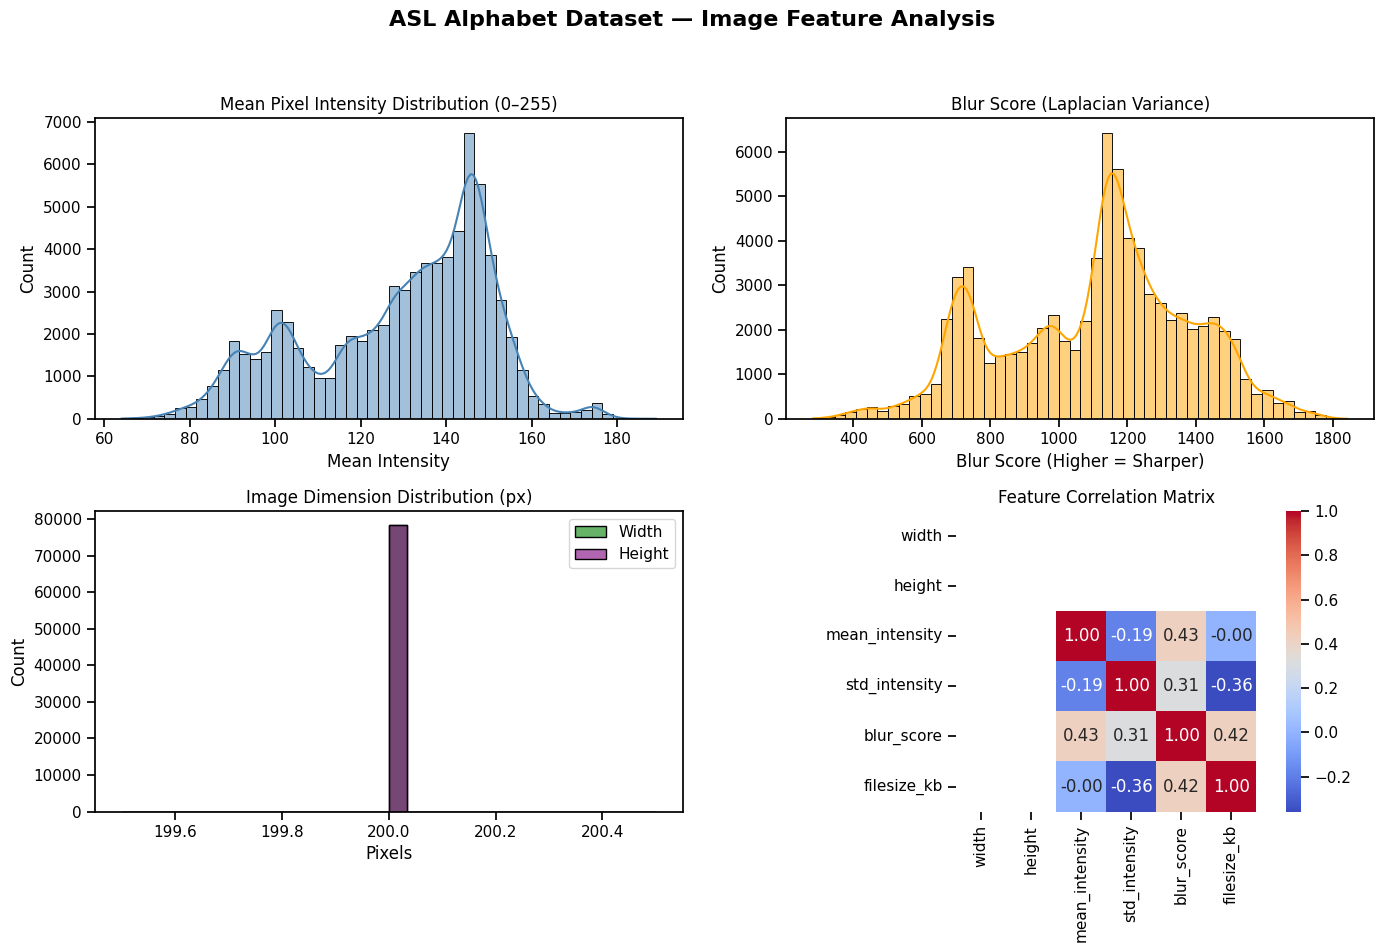

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("ASL Alphabet Dataset — Image Feature Analysis", fontsize=16, fontweight='bold')

# ---- 1. Mean Pixel Intensity Distribution ----
sns.histplot(df['mean_intensity'], bins=50, kde=True, ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Mean Pixel Intensity Distribution (0–255)')
axes[0, 0].set_xlabel('Mean Intensity')

# ---- 2. Blur Score Distribution ----
sns.histplot(df['blur_score'], bins=50, kde=True, ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Blur Score (Laplacian Variance)')
axes[0, 1].set_xlabel('Blur Score (Higher = Sharper)')

# ---- 3. Image Dimension Distribution ----
sns.histplot(df['width'], bins=30, ax=axes[1, 0], label='Width', color='green', alpha=0.6)
sns.histplot(df['height'], bins=30, ax=axes[1, 0], label='Height', color='purple', alpha=0.6)
axes[1, 0].set_title('Image Dimension Distribution (px)')
axes[1, 0].set_xlabel('Pixels')
axes[1, 0].legend()

# ---- 4. Correlation Matrix of Image Features ----
num_cols = ['width', 'height', 'mean_intensity', 'std_intensity', 'blur_score', 'filesize_kb']
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, ax=axes[1, 1])
axes[1, 1].set_title('Feature Correlation Matrix')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
